<a href="https://colab.research.google.com/github/shwldus067/colab/blob/main/Tagging_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b>태깅 작업</b></h1>
각 단어가 어떤 유형에 속하는지를 알아내는 작업
<ul>
<li>개체명 인식(Named Entity Recognition): 단어의 유형이 사람, 장소, 단체 등 어떤 유형인지 알아낸다.</li>
<li>품사 태깅(Part-of_speech Tagging): 각 단어의 품사가 명사, 동사, 형용사 인지를 알아낸다.</li>
</ul>

<h2>1. 케라스를 이용한 태깅 작업</h2>
개체명 인식기와 품사 태거를 만든다. RNN의 Many-to-Many 작업이면서 앞, 뒤 시점의 입력을 모두 참고하는 RNN(Bidirectional RNN)을 사용한다.
<ul>
<li><h3>훈련 데이터</h3>
X:태깅해야하는 단어 데이터<p>
y:레이블에 해당되는 태깅 정보<p>
X와 y데이터의 쌍은 병렬 구조를 갖는다. 정수 인코딩 후 패딩 작업을 거친다.
</li>
<li><h3>시퀀스 레이블링</h3>
X = [x1, x2, x3, ...,xn]에 대하여 레이블 시퀀스 y = [y1, y2, y3, ...,yn]를 각각 부여하는 작업<p>
태깅은 대표적인 시퀀스 레이블링 작업이다.
</li>
<li><h3>양방향 LSTM</h3>
이전 시점의 단어 정보와 다음 시점의 단어 정보도 참고하기 위해 Bidirectional LSTM을 사용한다. 기존의 단방향 LSTM()을 Bidirectional()안에 넣으면 된다.

```
model.add(Bidirectional(LSTM(hidden_size, return_sequences=True)))
```
</li>
<li><h3>RNN의 Many-to-Many 문제</h3>
태깅 작업할 때 Many-to-Many 문제로 return_sequences=True를 설정해 출력층에 모든 은닉 상태값을 보낸다.<p>
<img src="https://wikidocs.net/images/page/33805/forwardrnn_ver2.PNG"></img>
<p>양방향 RNN을 사용할 경우<p>
<img src="https://wikidocs.net/images/page/33805/bidirectionalrnn_ver2.PNG"></img>
</li>

<h2>2. 양방향 LSTM을 이용한 품사 태깅</h2>
직접 양방향 LSTM을 이용한 품사 태깅을 수행하는 모델 생성
<ul>
<li><h3>품사 태깅 데이터에 대한 이해와 전처리</h3>
</li>
</ul>

In [1]:
import nltk
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# nltk로 영어 코퍼스에 토큰화와 품사 태깅 전처리를 진행한 문장 데이터를 받아올 수 있다.

In [2]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [3]:
# 토큰화에 품사 태깅된 데이터 받아오기
tagged_sentences=nltk.corpus.treebank.tagged_sents()
# 문장 샘플의 개수 출력
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences))

품사 태깅이 된 문장 개수:  3914


In [4]:
# 첫 번째 샘플 출력
print(tagged_sentences[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [5]:
# 단어에 해당되는 부분과 품사 태깅 정보에 해당되는 부분 분리
sentences, pos_tags=[],[]
for tagged_sentence in tagged_sentences:
  sentence, tag_info=zip(*tagged_sentence)  # 단어들, 태깅 정보
  sentences.append(list(sentence))
  pos_tags.append(list(tag_info))

In [6]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


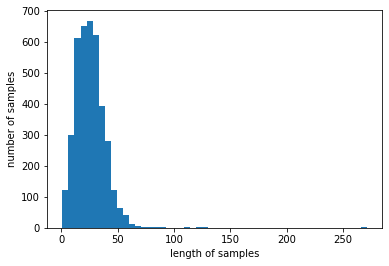

In [7]:
# 전체 데이터의 길이 분포
# 대부분 0~50의 길이를 갖는다.
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [8]:
# keras tokenizer
def tokenize(samples):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

In [9]:
# 문장 데이터와 품사 태깅 정보 토크나이저
src_tokenizer=tokenize(sentences)
tar_tokenizer=tokenize(pos_tags)

In [10]:
# 단어 집합과 품사 태깅 정보 집합의 크기
vocab_size=len(src_tokenizer.word_index)+1
tag_size=len(tar_tokenizer.word_index)+1
print('단어 집합의 크기:{}'.format(vocab_size))
print('태깅 정보 집합의 크기:{}'.format(tag_size))

단어 집합의 크기:11388
태깅 정보 집합의 크기:47


In [11]:
# 정수 인코딩
X_train=src_tokenizer.texts_to_sequences(sentences)
y_train=tar_tokenizer.texts_to_sequences(pos_tags)

In [12]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


In [13]:
# 샘플의 길이를 150으로 맞춰 padding
max_len=150
X_train=pad_sequences(X_train, padding='post', maxlen=max_len)
y_train=pad_sequences(y_train, padding='post', maxlen=max_len)

In [14]:
# split train:test=8:2
X_train, X_test, y_train, y_test=train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [15]:
# one-hot encoding
y_train=to_categorical(y_train, num_classes=tag_size)
y_test=to_categorical(y_test, num_classes=tag_size)

In [16]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150, 47)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150, 47)


<ul>
<li><h3>양방향 LSTM으로 POS Tagger 만들기</h3></li>
</ul>

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

In [18]:
model=Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [19]:
model.fit(X_train, y_train, batch_size=128, epochs=6, validation_data=(X_test, y_test))

Epoch 1/6
25/25 [==============================] - 29s 313ms/step - loss: 0.5716 - accuracy: 0.1460 - val_loss: 0.5050 - val_accuracy: 0.1617
Epoch 2/6
25/25 [==============================] - 2s 90ms/step - loss: 0.4878 - accuracy: 0.2435 - val_loss: 0.4521 - val_accuracy: 0.3821
Epoch 3/6
25/25 [==============================] - 2s 89ms/step - loss: 0.3909 - accuracy: 0.4510 - val_loss: 0.3079 - val_accuracy: 0.5380
Epoch 4/6
25/25 [==============================] - 2s 88ms/step - loss: 0.2417 - accuracy: 0.6403 - val_loss: 0.1771 - val_accuracy: 0.7604
Epoch 5/6
25/25 [==============================] - 2s 89ms/step - loss: 0.1268 - accuracy: 0.8401 - val_loss: 0.0987 - val_accuracy: 0.8637
Epoch 6/6
25/25 [==============================] - 2s 89ms/step - loss: 0.0661 - accuracy: 0.9173 - val_loss: 0.0652 - val_accuracy: 0.9044


In [20]:
print("\n테스트 정확도: %.4f"%(model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 0s 17ms/step - loss: 0.0652 - accuracy: 0.9044

테스트 정확도: 0.9044


In [21]:
# 단어와 품사 태깅 정보 리턴
index_to_word=src_tokenizer.index_word
index_to_tag=tar_tokenizer.index_word

i=10  # 확인할 테스트 샘플의 인덱스
y_predicted=model.predict(np.array([X_test[i]]))

# one-hot encoding을 정수 인코딩으로 변환
y_predicted=np.argmax(y_predicted, axis=-1)
true=np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     VBG
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .


<ul>
<li><h3>양방향 LSTM + CRF(Bi-directional LSTM + CRF)으로 POS tagger 만들기</h3>
양방향 LSTM에 CRF layer를 추가해 성능을 높인다.
</li>
</ul>

In [22]:
!pip install tf2crf

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [23]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Input
from tf2crf import CRF, ModelWithCRFLoss

In [24]:
# 이전 모델에 CRF layer 추가
inputs = Input(shape=(None,), dtype='int32')
output = Embedding(vocab_size, 128, mask_zero=True)(inputs)
output = Bidirectional(LSTM(128, return_sequences=True))(output)
crf = CRF(tag_size)
output = crf(output)
base_model = Model(inputs, output)

model = ModelWithCRFLoss(base_model, sparse_target=False)
model.build(input_shape=(None, 22))
model.compile(optimizer='adam')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: CRF decoding models have serialization issues in TF >=2.5 . Please see isse #2476
  return py_builtins.overload_of(f)(*args)


In [25]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_split = 0.2, verbose = 1)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: CRF decoding models have serialization issues in TF >=2.5 . Please see isse #2476
  return py_builtins.overload_of(f)(*args)


79/79 [==============================] - 67s 701ms/step - loss: 76.7042 - accuracy: 0.2508 - val_loss_val: 56.8613 - val_val_accuracy: 0.4756
Epoch 2/5
79/79 [==============================] - 52s 657ms/step - loss: 35.9907 - accuracy: 0.6533 - val_loss_val: 19.7528 - val_val_accuracy: 0.8272
Epoch 3/5
79/79 [==============================] - 51s 653ms/step - loss: 11.7635 - accuracy: 0.9005 - val_loss_val: 9.5466 - val_val_accuracy: 0.9039
Epoch 4/5
79/79 [==============================] - 51s 642ms/step - loss: 5.1243 - accuracy: 0.9569 - val_loss_val: 7.3160 - val_val_accuracy: 0.9189
Epoch 5/5
79/79 [==============================] - 51s 643ms/step - loss: 3.0251 - accuracy: 0.9732 - val_loss_val: 6.4752 - val_val_accuracy: 0.9256


In [26]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 6s 250ms/step - loss_val: 6.3040 - val_accuracy: 0.9298

 테스트 정확도: 0.9290


<h2>3. 개체명 인식(Named Entity Recognition)</h2>
코퍼스에서 어떤 단어가 사람, 장소, 조직 등을 의미하는 단어인지를 찾는다.
<ul>
<li><h3>개체명 인식이란</h3>
이름을 가진 개체를 인식한다. 단어가 어떤 유형인지를 인식한다. 전처리과정이 필요하고 모델에 따라 품사 정보를 입력으로 요구하기도 한다.
</li>
<li><h3>NLTK를 이용한 개체명 인식</h3>
</li>
</ul>

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from nltk import word_tokenize, pos_tag, ne_chunk
sentence = "James is working at Disney in London"
sentence=pos_tag(word_tokenize(sentence))
print(sentence) # 토큰화와 품사 태깅을 동시 수행

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


In [ ]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

In [ ]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
sentence=ne_chunk(sentence) # 품사 태깅이 필요
print(sentence)

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


<h2>4. 개체명 인식의 BIO 표현</h2>
직접 목적에 맞는 데이터를 준비해 훈련시켜 모델을 만드는 것이 더 개체명 인식을 정확하게 한다.
<ul>
<li><h3>BIO 표현</h3>
IOB(또는 BIO): Begin(개체명이 시작되는 부분), Inside(개체명의 내부 부분), Outside(개체명이 아닌 부분)의 약자
</li>
<li><h3>개체명 인식 데이터</h3>
양방향 LSTM을 이용한 개체명 인식<p>
CONLL2003: 개체명 인식을 위한 전통적인 영어 데이터 셋<p>
[단어] [품사태깅] [청크태깅] [개체명태깅]의 형식

```
EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER
```
Peter Blackburn이 person에 속하는 하나의 개체명이다.

</li
<li><h3>데이터 전처리</h3>
</li>
</ul>

In [4]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [5]:
from urllib import request
# 데이터 다운로드
request.urlretrieve('https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt', "train.txt")

('train.txt', <http.client.HTTPMessage at 0x7f4312e2d110>)

In [6]:
# 데이터 전처리
f = open('/content/train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence) # 문장별로 나눠서 저장
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.

In [7]:
print("전체 샘플 개수: ", len(tagged_sentences))

전체 샘플 개수:  14041


In [8]:
print(tagged_sentences[0])

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [ ]:
# 단어와 개체명 태깅 분리
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence) # 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [ ]:
# X:sentences, y:ner_tags로 사용된다.
print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [ ]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


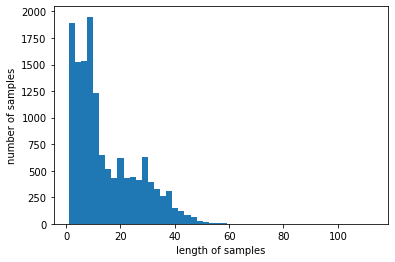

In [ ]:
# 데이터의 길이 분포
# 대체로 0~40, 0~20이 대다수
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 토큰화
# 높은 빈도수를 갖는 4000개의 단어만을 선택
max_words = 4000
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [ ]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


In [ ]:
# 정수 인코딩
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [ ]:
print(X_train[0])
print(y_train[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


In [ ]:
# 디코딩 배열
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [ ]:
# 첫 번째 문장 디코딩
decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [ ]:
# 길이 70으로 padding
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [ ]:
# 데이터 split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [ ]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


<ul>
<li><h3>양방향 LSTM으로 개체명 인식기 만들기</h3>
</li>
</ul>

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
# 데이터에서 숫자 0은 연산에서 제외
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))  # LSTM, Many-to-Many
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=8,  validation_data=(X_test, y_test))

Epoch 1/8
88/88 [==============================] - 24s 97ms/step - loss: 0.1892 - accuracy: 0.8241 - val_loss: 0.1295 - val_accuracy: 0.8332
Epoch 2/8
88/88 [==============================] - 6s 67ms/step - loss: 0.1035 - accuracy: 0.8503 - val_loss: 0.0795 - val_accuracy: 0.8794
Epoch 3/8
88/88 [==============================] - 6s 67ms/step - loss: 0.0697 - accuracy: 0.8971 - val_loss: 0.0577 - val_accuracy: 0.9151
Epoch 4/8
88/88 [==============================] - 6s 69ms/step - loss: 0.0496 - accuracy: 0.9298 - val_loss: 0.0427 - val_accuracy: 0.9403
Epoch 5/8
88/88 [==============================] - 6s 66ms/step - loss: 0.0368 - accuracy: 0.9487 - val_loss: 0.0375 - val_accuracy: 0.9481
Epoch 6/8
88/88 [==============================] - 5s 59ms/step - loss: 0.0302 - accuracy: 0.9572 - val_loss: 0.0335 - val_accuracy: 0.9537
Epoch 7/8
88/88 [==============================] - 5s 59ms/step - loss: 0.0258 - accuracy: 0.9631 - val_loss: 0.0326 - val_accuracy: 0.9553
Epoch 8/8
88/88 [==

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

88/88 [==============================] - 2s 18ms/step - loss: 0.0320 - accuracy: 0.9574

 테스트 정확도: 0.9574


In [ ]:
# 실제 값과 비교해 확인
i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 예측 y
y_predicted = np.argmax(y_predicted, axis=-1) # 정수 인코딩으로 변경
true = np.argmax(y_test[i], -1) # 정수 인코딩으로 변경

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              : O       O
pre

<h2>5. 양방향 LSTM을 이용한 개체명 인식</h2>
F1-Score를 사용해 모델을 평가한다.
<ul>
<li><h3>CRF 사용 조건</h3></li>
버전을 맞춰야 원활하게 동작이 가능하다.
</ul>

In [2]:
!pip uninstall keras-nightly
!pip uninstall -y tensorflow
!pip install tensorflow==1.14.0
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.14.0
!pip install h5py==2.10.0

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
     |████████████████████████████████| 109.3 MB 48 kB/s 
     |████████████████████████████████| 488 kB 42.4 MB/s 
     |████████████████████████████████| 3.1 MB 42.9 MB/s 
     |████████████████████████████████| 50 kB 5.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.14.0 which is incompatible.


In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [5]:
# keras_contrib 설치 필요
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-hp7upkap
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-hp7upkap
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=597c6f2d9db8ab910b7f0380e0b9b8d9aa409c5767671243ab8976a67607cd80
  Stored in directory: /tmp/pip-ephem-wheel-cache-japu6ij8/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


<ul>
<li><h3>개체명 인식 데이터에 대한 이해와 전처리</h3></li>
</ul>

In [6]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [7]:
data = pd.read_csv("/content/ner_dataset.csv", encoding="latin1")
data[:10]
# 하나의 문장을 여러 행으로 나눠놓음
# "sentence: k"가 나오고 NULL이 나오다가 "sentence: k+1"이 반복됨

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [4]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 1048575


In [5]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : True


In [6]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [112]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


In [113]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [8]:
# Null을 제거(Null을 가진 행의 바로 앞의 행의 값으로 Null을 채운다.)
# "sentence: k"가 반복적으로 채워진다.
data = data.fillna(method="ffill")

In [7]:
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [116]:
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


In [9]:
# 단어 소문자화
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 31817


In [10]:
# 단어, 태깅 정보 매칭
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences=[t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 개수: {}".format(len(tagged_sentences)))

전체 샘플 개수: 47959


In [10]:
print(tagged_sentences[0])

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [11]:
# 단어와 태깅 정보 분리
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [12]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


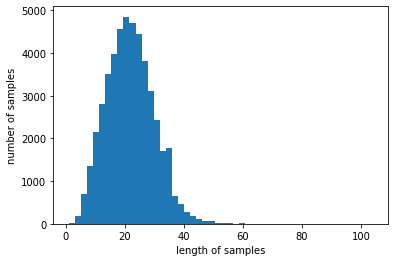

In [122]:
# 데이터 길이 분포
# 대체로 0~40
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [12]:
# keras tokenizer로 정수 인코딩
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [13]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [125]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [14]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [127]:
print(X_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [15]:
# 모델 훈련 후 결과 확인
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [129]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [130]:
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [16]:
# 길이 70으로 패딩
max_len = 70
# 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.2, random_state=777)

In [18]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [18]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


<ul>
<li><h3>F1-Score</h3>
큰 의미를 갖지 않는 레이블 정보가 대다수의 레이브를 차지하기 때문에 새로운 정확도 측정 방법이 필요하다.<p>
정밀도: 특정 개체라고 예측한 것이 일치한 비율<p>
재현률: 전체 특정 개체 중 실제 특정 개체라고 맞춘 비율<p>
F1-score: 이들의 조화 평균을 구한 것<p>
F1-score=2x(정밀도*재현률)/(정밀도+재현률)<p>
</li>
</ul>

In [18]:
!pip install seqeval

In [19]:
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O']

In [20]:
from seqeval.metrics import classification_report
print(classification_report([true], [predicted]))
# 정밀도는 1, 재현률을 보면 맞추지 못한 개체가 있다.

              precision    recall  f1-score   support

        MISC       1.00      0.50      0.67         2
         PER       1.00      0.67      0.80         3

   micro avg       1.00      0.60      0.75         5
   macro avg       1.00      0.58      0.73         5
weighted avg       1.00      0.60      0.75         5



<ul>
<li><h3>F1-Score callback class</h3>
모델을 검증하는 과정에서 F1-socre를 지속적으로 확인하고 F1-score가 가장 높을 때마다 모델 저장
</li>
</ul>

In [21]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report

Using TensorFlow backend.


In [22]:
class F1score(Callback):
    def __init__(self, value = 0.0, use_char=True):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
      result = []
      for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
          tag = []
          for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
              pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
              tag.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
          result.append(tag)
      return result

    # 에포크가 끝날 때마다 실행되는 함수
    def on_epoch_end(self, epoch, logs={}):

      # char Embedding을 사용하는 경우
      if self.use_char:
        X_test = self.validation_data[0]
        X_char_test = self.validation_data[1]
        y_test = self.validation_data[2]
        y_predicted = self.model.predict([X_test, X_char_test])

      else:
        X_test = self.validation_data[0]
        y_test = self.validation_data[1]
        y_predicted = self.model.predict([X_test])

      pred_tags = self.sequences_to_tags(y_predicted)
      test_tags = self.sequences_to_tags(y_test)

      score = f1_score(pred_tags, test_tags)
      print(' - f1: {:04.2f}'.format(score * 100))
      print(classification_report(test_tags, pred_tags))

      # F1-score가 지금까지 중 가장 높은 경우
      if score > self.value:
        print('f1_score improved from %f to %f, saving model to best_model.h5'%(self.value, score))
        self.model.save('best_model.h5')
        self.value = score
      else:
        print('f1_score did not improve from %f'%(self.value))

<ul>
<li><h3>BiLSTM이용한 개체명인식기</h3>
</li>
</ul>

In [23]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from keras.optimizers import Adam
from keras.models import load_model

In [24]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [28]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10,  validation_split=0.1, callbacks=[F1score(use_char=False)])


Train on 34530 samples, validate on 3837 samples
Epoch 1/10
34530/34530 [==============================] - 314s 9ms/step - loss: 0.0923 - accuracy: 0.9253 - val_loss: 0.0466 - val_accuracy: 0.9555
 - f1: 74.91


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        37
         eve       0.00      0.00      0.00        30
         geo       0.78      0.86      0.82      3087
         gpe       0.89      0.94      0.91      1146
         nat       0.00      0.00      0.00        16
         org       0.61      0.45      0.52      1691
         per       0.63      0.69      0.66      1310
         tim       0.80      0.79      0.80      1672

   micro avg       0.75      0.75      0.75      8989
   macro avg       0.46      0.47      0.46      8989
weighted avg       0.74      0.75      0.74      8989

f1_score improved from 0.000000 to 0.749093, saving model to best_model.h5
Epoch 2/10
34530/34530 [==============================] - 306s 9ms/step - loss: 0.0364 - accuracy: 0.9649 - val_loss: 0.0402 - val_accuracy: 0.9604
 - f1: 77.11
              precision    recall  f1-score   support

         art       0.00      0.00      0.00        37
    

<h2>6. 양방향 LSTM과 CRF</h2>
<ul>
<li><h3>CRF(Conditional Random Field)</h3>
활성화 함수의 결과가 CRF 층의 입력으로 전달되어 레이블 시퀀스 중 가장 높은 점수를 갖는 시퀀스를 예측한다.<p>
<img src="https://wikidocs.net/images/page/34156/bilstmcrf3.PNG"></img><p>
양방향 LSTM은 입력 단어에 대한 양방향 문맥을 반영하고, CRF는 출력 레이블에 대한 양방향 문맥을 반영한다.
<li><h3>버전 조건</h3>
</li>
</ul>

In [4]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.14.0

     |████████████████████████████████| 50 kB 3.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.14.0 which is incompatible.
  Using cached Keras-2.2.4-py2.py3-none-any.whl (312 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0


In [30]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-db0t4yf0
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-db0t4yf0


<ul>
<li><h3>개체명 인식 데이터, F1-score callback class</h3>
위의 데이터 사용
</li>
<li><h3>양방향 LSTM+CRF</h3>
</li>
</ul>

In [30]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.models import load_model
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

In [31]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(50, activation="relu")))
crf = CRF(tag_size)
model.add(crf)

<h2>7. 양방향 LSTM과 글자 임베딩(Char embedding)</h2>
개체명 인식기의 성능을 올리기 위해 워드 임베딩에 글자 임베딩을 연결한다.
<ul>
<li><h3>글자 임베딩을 위한 전처리</h3>
글자 단위 정수 인코딩
</li>
</ul>

In [19]:
# char_vocab 만들기
words = list(set(data["Word"].values))
chars = set([w_i for w in words for w_i in w])
chars = sorted(list(chars))
print(chars)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x85', '\x91', '\x92', '\x93', '\x94', '\x96', '\x97', '\xa0', '°', 'é', 'ë', 'ö', 'ü']


In [35]:
char_to_index = {c: i + 2 for i, c in enumerate(chars)}
char_to_index["OOV"] = 1
char_to_index["PAD"] = 0

index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [36]:
max_len_char = 15

def padding_char_indice(char_indice, max_len_char):
  return pad_sequences(
        char_indice, maxlen=max_len_char, padding='post', value = 0)

def integer_coding(sentences):
  char_data = []
  for ts in sentences:
    word_indice = [word_to_index[t] for t in ts]
    char_indice = [[char_to_index[char] for char in t]  
                                          for t in ts]
    char_indice = padding_char_indice(char_indice, max_len_char)

    for chars_of_token in char_indice:
      if len(chars_of_token) > max_len_char:
        continue
    char_data.append(char_indice)
  return char_data

In [ ]:
X_char_data = integer_coding(sentences)

In [36]:
# 기존 문장
print(sentences[0])
# 단어 인코딩+패딩
print(X_data[0])
# 글자 인코딩
print(X_char_data[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
[ 254    6  967   16 1795  238  468    7  523    2  129    5   61    9
  571    2  833    6  186   90   22   15   56    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
[[53 41 48 54 52 34 47 37 52  0  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 48 47 52 53 51 34 53 48 51 52  0  0]
 [41 34 55 38  0  0  0  0  0  0  0  0  0  0  0]
 [46 34 51 36 41 38 37  0  0  0  0  0  0  0  0]
 [53 41 51 48 54 40 41  0  0  0  0  0  0  0  0]
 [45 48 47 37 48 47  0  0  0  0  0  0  0  0  0]
 [53 48  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [49 51 48 53 38 52 53  0  0  0  0  0  0 

In [37]:
max_len

70

In [38]:
# 문장 길이를 70으로 패딩
X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value = 0)

In [39]:
X_char_train, X_char_test, _, _ = train_test_split(X_char_data, y_data, test_size=.2, random_state=777)

X_char_train = np.array(X_char_train)
X_char_test = np.array(X_char_test)

In [40]:
print(X_train[0])

[ 150  928  361   17 2624    9 4131 3567    9    8 2893 1250  880  107
    3    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [41]:
print(' '.join([index_to_char[index] for index in X_char_train[0][0]]))

s o l d i e r s PAD PAD PAD PAD PAD PAD PAD


<ul>
<li><h3>BiLSTM-CNN</h3>
전처리한 글자 단위 정수 인코딩 입력을 1D CNN의 입력으로 사용해 글자 임베딩을 얻고, 워드 임베딩과 연결해 양방향 LSTM의 입력으로 사용한다.
</li>
</ul>

In [33]:
from keras.layers import Embedding, TimeDistributed, Dropout, concatenate, Bidirectional, LSTM, Conv1D, Dense, MaxPooling1D, Flatten
from keras import Input, Model
from keras.initializers import RandomUniform
from keras.models import load_model

In [ ]:
# 워드 임베딩
word_ids = Input(shape=(None,),dtype='int32',name='words_input')
word_embeddings = Embedding(input_dim = vocab_size, output_dim = 64)(word_ids)

# char 임베딩
char_ids = Input(shape=(None, max_len_char,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_ids)
dropout = Dropout(0.5)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char_embeddings = TimeDistributed(Flatten())(maxpool_out)
char_embeddings = Dropout(0.5)(char_embeddings)

# char 임베딩을 Conv1D 수행한 뒤에 워드 임베딩과 연결
output = concatenate([word_embeddings, char_embeddings])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(50, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='softmax'))(output)

model = Model(inputs=[word_ids, char_ids], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='nadam',  metrics=['acc'])

<ul>
<li><h3>BiLSTM-CNN-CRF</h3>
위의 모델에 CRF층을 추가한다.
</li>
</ul>

In [ ]:
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

In [ ]:
# 워드 임베딩
word_ids = Input(shape=(None,),dtype='int32',name='words_input')
word_embeddings = Embedding(input_dim = vocab_size, output_dim = 64)(word_ids)

# char 임베딩
char_ids = Input(shape=(None, max_len_char,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_ids)
dropout = Dropout(0.5)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char_embeddings = TimeDistributed(Flatten())(maxpool_out)
char_embeddings = Dropout(0.5)(char_embeddings)

# char 임베딩을 Conv1D 수행한 뒤에 워드 임베딩과 연결
output = concatenate([word_embeddings, char_embeddings])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(50, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(output)

# 출력층에 CRF 층을 추가 (위의 모델과 이 부분이 다릅니다.)
output = TimeDistributed(Dense(50, activation='relu'))(output)
crf = CRF(tag_size)
output = crf(output)

model = Model(inputs=[words_input, character_input], outputs=[output])

In [ ]:
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
history = model.fit([X_train, X_char_train], y_train, batch_size = 32, epochs = 15, validation_split = 0.1, verbose = 1, callbacks=[F1score(use_char=True)])

<ul>
<li><h3>BiLSTM-BiLSTM-CRF</h3>
양방향 LSTM을 이용해 글자 임베딩해서 워드 임베딩과 연결하고 CRF 층을 추가한다.
</li>
</ul>

In [ ]:
# 워드 임베딩
word_ids = Input(batch_shape=(None, None), dtype='int32', name='word_input')
word_embeddings = Embedding(input_dim=vocab_size,
                                        output_dim=64,
                                        mask_zero=True,
                                        name='word_embedding')(word_ids)

# char 임베딩
char_ids = Input(batch_shape=(None, None, None), dtype='int32', name='char_input')
char_embeddings = Embedding(input_dim=(len(char_to_index)),
                                        output_dim=30,
                                        mask_zero=True,
                                        embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5),
                                        name='char_embedding')(char_ids)

char_embeddings = TimeDistributed(Bidirectional(LSTM(64)))(char_embeddings)

# char 임베딩을 워드 임베딩과 연결
word_embeddings = concatenate([word_embeddings, char_embeddings])

word_embeddings = Dropout(0.3)(word_embeddings)
z = Bidirectional(LSTM(units=64, return_sequences=True))(word_embeddings)
z = Dense(tag_size, activation='tanh')(z)
crf = CRF(tag_size)
output = crf(z)

model = Model(inputs=[word_ids, char_ids], outputs=[output])

In [ ]:
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
history = model.fit([X_train, X_char_train], y_train, batch_size = 32, epochs = 15, validation_split = 0.1, verbose = 1, callbacks=[F1score(use_char=True)])